In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, DeepAR
from pytorch_forecasting.models.base_model import AutoRegressiveBaseModelWithCovariates, BaseModelWithCovariates, AutoRegressiveBaseModel
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [3]:
raw_col = ['date', 'highest', 'high', 'mid', 'low', 'ave', 'ave_dif', 'volume', 'vol_dif', 'resid']
raw = pd.read_csv('FS443.csv',names=raw_col).drop(['ave_dif', 'vol_dif', 'resid'], axis=1)
for i in range(raw.shape[0]):
    raw.volume[i] = int(raw.volume[i].split(' ')[0].replace(',', ''))
raw.volume = raw.volume.values.astype('int')

ts_date = raw.copy().date
for itr in range(raw.shape[0]):
    date = raw.date[itr].split('/')
    date[0] = str(int(date[0]) + 1911)
    result = '/'.join(date)
    ts_date[itr] =  np.datetime64(datetime.strptime(result, "%Y/%m/%d").date())
    
raw.date = ts_date
raw['date'] = pd.to_datetime(raw['date'], errors='coerce')

t_index = []
group = []
for i in range(raw.shape[0]):
    t_index.append(i)
    group.append(str(0))

raw["time_idx"] = t_index
raw["group"] = group

raw["month"] = raw.date.dt.month.astype(str).astype("category")

ge

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
max_prediction_length = 14 
max_encoder_length = 30 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


In [5]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [4]:
max_prediction_length = 14 
max_encoder_length = 30 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    static_categoricals=["group"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.12882495516931336


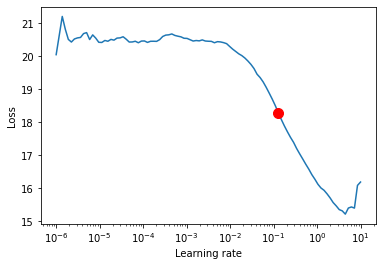

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [5]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [6]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1288,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [7]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 36.88999938964844


### M1

In [19]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.17782794100389226


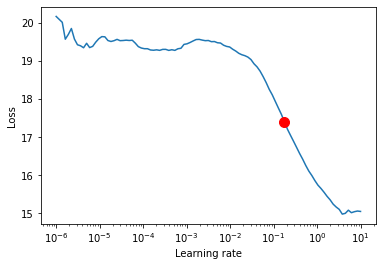

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


In [20]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [22]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.177,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k


In [23]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [24]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [28]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 32.54999923706055


In [30]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-01-16 14:31:46,562] A new study created in memory with name: no-name-18a1a7c8-83f9-4b44-aa9a-fe0c4d609717
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-16 14:57:46,128] Trial 0 finished with value: 7.343421459197998 and parameters: {'gradient_clip_val': 0.040213247946615925, 'hidden_size': 82, 'dropout': 0.15260137132515167, 'hidden_continuous_size': 52, 'attention_head_size': 1, 'learning_rate': 0.0017441753922462526}. Best is trial 0 with value: 7.343421459197998.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-16 20:56:39,750] Trial 1 finished with value: 10.627753257751465 and parameters: {'gradient_clip_val': 0.1730721404896964, 'hidden_size': 21, 'dropout': 0.1134506390197932, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.0015704837526945333}. Best is trial 0 with value: 7.343421459197998.
G

TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-16 21:50:53,564] Trial 35 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-16 21:52:18,169] Trial 36 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-16 21:53:39,069] Trial 37 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-16 21:54:16,267] Trial 38 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2021-01-16 21:54:48,347] Trial 39 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA

NameError: name 'pickle' is not defined

In [32]:
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

In [33]:
print(study.best_trial.params)

{'gradient_clip_val': 0.19611651879668976, 'hidden_size': 33, 'dropout': 0.24522551373671678, 'hidden_continuous_size': 10, 'attention_head_size': 3, 'learning_rate': 0.01905939360124749}


### M1 tuning

In [34]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.196,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01905939360124749,
    hidden_size=33,
    attention_head_size=3,
    dropout=0.2452,
    hidden_continuous_size=10,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 70.6k


In [35]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 200   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 9.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.6 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.6 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.6 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [36]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 41.20000076293945


### change min_encode_length to 0

In [4]:
max_prediction_length = 14 
max_encoder_length = 60 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=0,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.07943282347242808


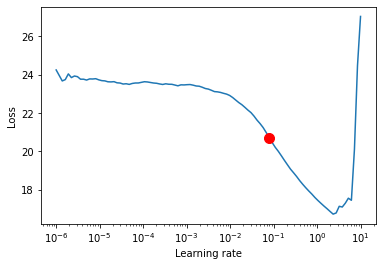

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [5]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()



In [6]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.079432,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [7]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 30.889999389648438


In [6]:
max_prediction_length = 14 
max_encoder_length = 30 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=0,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.09332543007969905


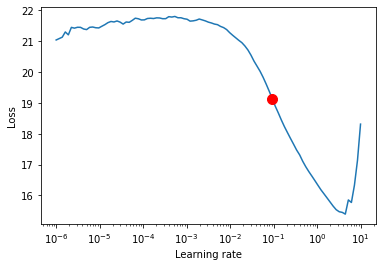

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [7]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()



In [8]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09332,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 32.2400016784668


### change encoding size to 14

In [4]:
max_prediction_length = 14 
max_encoder_length = 14 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    static_categoricals=["group"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.10964781961431845


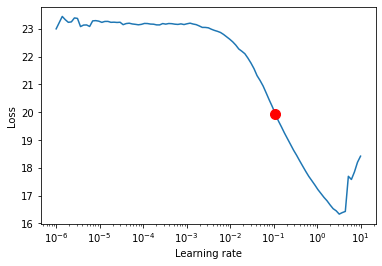

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [5]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [6]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1096478,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [8]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33.81999969482422


In [6]:
max_prediction_length = 14 
max_encoder_length = 14 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.07943282347242808


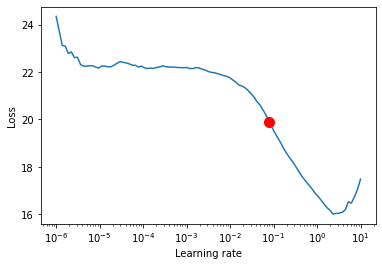

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [7]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [8]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.079,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 35.0


### change to use only ave

In [4]:
max_prediction_length = 14 
max_encoder_length = 60 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave"
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 18.0k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.15135612484362077


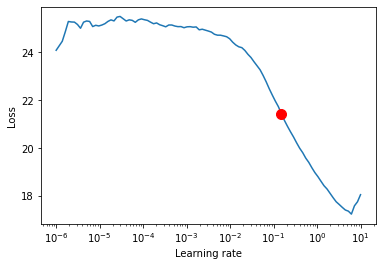

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [5]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [6]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.15135,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 18.0k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [7]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 35.81999969482422


### Change encoding to size 60

In [4]:
max_prediction_length = 14 
max_encoder_length = 60 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=
        "ave"
    ,
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


In [5]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.07943282347242808


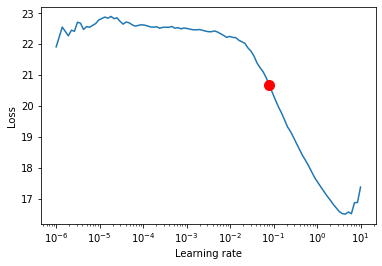

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [7]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss= QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [ ]:
0.07943282347242808

In [10]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.07943282347242808,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss= QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedRe

Number of parameters in network: 21.4k


Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [13]:
max_prediction_length = 14 
max_encoder_length = 60 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=[
        "ave",
        "high",
        "mid",
        "volume",
    ],
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:517: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [6]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [20]:
from pytorch_forecasting.metrics import QuantileLoss, MultiLoss

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.8k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 2.754228703338168


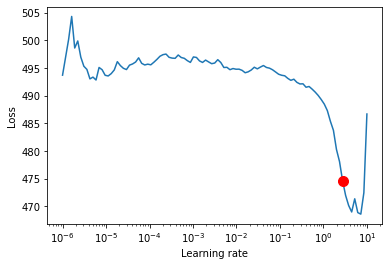

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [24]:
# # create validation set (predict=True) which means to predict the last max_prediction_length points in time
# # for each series
# validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# # create dataloaders for model
# batch_size = 128  # set this between 32 to 128
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    n_targets = 4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=[7,7,7,7],  # 7 quantiles by default
    loss=MultiLoss([QuantileLoss(),QuantileLoss(), QuantileLoss(), QuantileLoss()]),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [9]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [26]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=2.754228703338168,
    hidden_size=16,
    attention_head_size=1,
    n_targets = 4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=[7,7,7,7],  # 7 quantiles by default
    loss=MultiLoss([QuantileLoss(),QuantileLoss(), QuantileLoss(), QuantileLoss()]),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.8k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [ ]:
mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [51]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# actuals = torch.cat([y[0][3] for x, y in iter(val_dataloader)])
# predictions = best_tft.predict(val_dataloader)
preds, index =  best_tft.predict(val_dataloader, return_index=True, fast_dev_run=True)
preds, index



([tensor([[159.7168, 159.8607, 160.5637, 162.0109, 162.5600, 162.7039, 162.7495,
           162.7681, 162.7774, 162.7826, 162.7859, 162.7884, 162.7903, 164.0927],
          [119.3410, 119.3403, 119.3343, 119.3199, 119.3136, 119.3118, 119.3112,
           119.3110, 119.3109, 119.3108, 119.3107, 119.3106, 119.3105, 119.2921],
          [119.5304, 119.5309, 119.5332, 119.5351, 119.5348, 119.5346, 119.5346,
           119.5345, 119.5345, 119.5345, 119.5345, 119.5345, 119.5345, 119.5303],
          [124.4570, 124.4598, 124.4712, 124.4938, 124.5018, 124.5038, 124.5045,
           124.5047, 124.5048, 124.5049, 124.5049, 124.5049, 124.5049, 124.5184]])],
    time_idx group
 0      6630     0)

In [53]:
predictions[0].numpy()[0]

array([159.71684, 159.86073, 160.5637 , 162.01093, 162.56004, 162.70386,
       162.7495 , 162.76814, 162.77736, 162.7826 , 162.78595, 162.78838,
       162.79027, 164.09268], dtype=float32)

In [59]:
mse = ((raw[-14:].ave - predictions[0].numpy()[3]) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), )))

The Root Mean Squared Error of our forecasts is 32.02


In [33]:
raw[-14:]

,highest,high,mid,low,ave,volume,time_idx,group,month
6630,149,125,74,58,80.7,399,6630,0,11
6631,169,157,115,81,116.6,189,6631,0,11
6632,170,141,108,52,103.3,301,6632,0,11
6633,140,126,88,77,93.6,294,6633,0,11
6634,161,144,95,75,100.5,147,6634,0,11
6635,142,142,118,74,113.7,224,6635,0,11
6636,160,160,141,106,137.7,153,6636,0,11
6637,171,168,151,83,140.7,177,6637,0,11
6638,176,176,170,161,169.4,102,6638,0,11
6639,201,201,137,67,134.9,97,6639,0,11


In [40]:
actuals

tensor([[348, 139, 251, 244,  99, 174, 105, 128,  62,  58, 127,  46,  51,   9]])

In [ ]:
for x, y in iter(val_dataloader)

In [11]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 28.290000915527344


In [ ]:
max_prediction_length = 14 
max_encoder_length = 60 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.09332543007969905


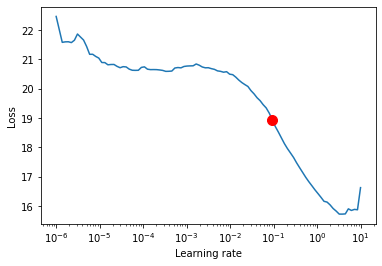

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [7]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [8]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.093325,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 31.06999969482422


### change encoding size to 365

In [6]:
max_prediction_length = 14 
max_encoder_length = 365 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.10964781961431845


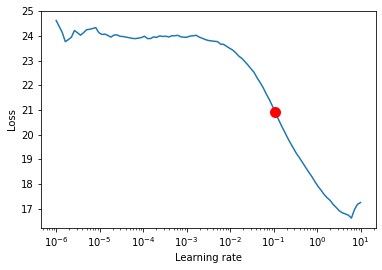

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [7]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [8]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1096478,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 31.860000610351562


In [7]:
max_prediction_length = 14 
max_encoder_length = 180 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.10964781961431845


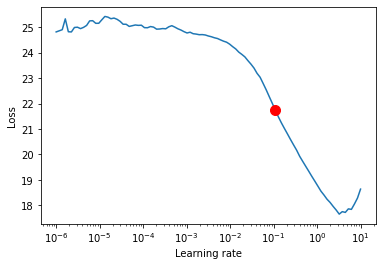

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [8]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [11]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1096478,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [12]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 36.40999984741211


In [6]:
max_prediction_length = 14 
max_encoder_length = 365 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)



C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
C:\Users\user\anaconda3\envs\TSA\lib\site-packages\pytorch_forecasting\data\timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 0.09332543007969905


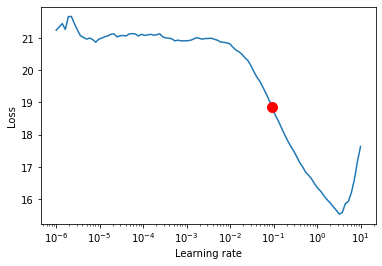

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [7]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [8]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.093325,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 21.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 666   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 33.7599983215332


In [ ]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.177,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

### N-BEATS

In [4]:
max_prediction_length = 14 
max_encoder_length = 60 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=[
        "ave"
    ]
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at C:\Users\user\Desktop\Python\TSA_final\lr_find_temp_model.ckpt


suggested learning rate: 5.623413251903491e-05


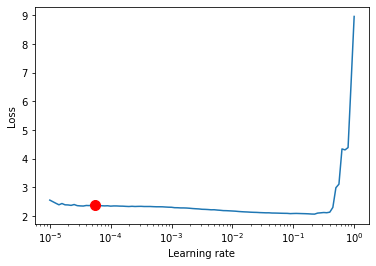

C:\Users\user\anaconda3\envs\TSA\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


In [5]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=[0], gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [6]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=5.623e-05,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params


Validation sanity check: |                                                                       | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

Validating: |                                                                                    | 0/? [00:00<…

1

In [8]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)

mse = ((actuals - predictions) ** 2).mean().numpy()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 32.0


### Autoregressive

In [6]:
max_prediction_length = 14 
max_encoder_length = 60 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    static_categoricals=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_encoder_length=False
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [7]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=[0],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


ARBC = BaseModelWithCovariates.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    # number of attention heads. Set to up to 4 for large datasets
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = trainer.tuner.lr_find(
    ARBC,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TypeError: __init__() got an unexpected keyword argument 'static_categoricals'

# Simple nn

In [ ]:

from pytorch_forecasting.models import BaseModel


class FullyConnectedModel(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)

        # We need to return a dictionary that at least contains the prediction and the target_scale.
        # The parameter can be directly forwarded from the input.
        return dict(prediction=prediction, target_scale=x["target_scale"])


model = FullyConnectedModel(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)

In [ ]:
max_prediction_length = 14 
max_encoder_length = 30 # need to be tuned
training_cutoff = raw["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    raw[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ave",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # can be tuned
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month"],
    time_varying_unknown_reals=[
        "ave",
        "highest",
        "high",
        "mid",
        "low",
        "volume",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, raw, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)